# Imputation multiple avec MICE

- *Auteurs :* Quentin Grimonprez, Cristian Preda, Vincent Vandewalle
- *Date :* 16 février 2020

On utilise le package [pandas](https://pandas.pydata.org/pandas-docs/stable/) pour manipuler des dataFrames (tableau pouvant contenir des types différents entre les colonnes) et le package [statsmodels](https://www.statsmodels.org/stable/api.html) pour l'imputation multiple (statsmodels contient principalement des méthodes de régressions (avec plus d'analyses statistiques que scikit-learn) et séries temporelles). Dans [scikit-learn](https://scikit-learn.org/stable/modules/impute.html), il est pour l'instant uniquement possible de faire de l'imputation basée sur des méthodes simples (moyenne, valeur la plus fréquente...), une implémentation de [MICE](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) est en mode expérimental.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.imputation import mice

plt.rcParams["figure.figsize"] = (8, 8)

## Aperçu des données

Chargement des données airquality à partir du fichier fourni. En ouvrant ce fichier, on notera que les manquants de la variable *Ozone* sont codés par la valeur `-9` tandis que ceux de la variable Solar.R le sont par `NA`.

In [2]:
airquality = pd.read_table(
    "data/airquality2.txt", sep=" ", header=[0], na_values={"Ozone": -9, "Solar.R": "NA"}, dtype={"Month": str, "Day": str}
)
# les fonctions de modélisation de statsmodels ne supportent pas les "." dans les noms.
# Le paramètre inplace=True indique qu'il faut modifier directement le DataFrame et non retourner une copie.
airquality.rename(columns={"Solar.R": "SolarR"}, inplace=True)
airquality.head()

,Ozone,SolarR,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


On vérifie le type des colonnes. Les chaînes de caractères sont de type *object*.

In [3]:
airquality.dtypes

Ozone     float64
SolarR    float64
Wind      float64
Temp        int64
Month      object
Day        object
dtype: object

#### Statistiques univariées

In [4]:
print(airquality.shape)
# par défaut, calcule les statistiques pour les variables numériques.
# Si vous voulez des statistiques sur toutes les variables, ajoutez le paramètre include="all"
airquality.describe()

(153, 6)


,Ozone,SolarR,Wind,Temp
count,116.000000,146.000000,153.000000,153.000000
mean,42.129310,185.931507,9.957516,77.882353
std,32.987885,90.058422,3.523001,9.465270
min,1.000000,7.000000,1.700000,56.000000
25%,18.000000,115.750000,7.400000,72.000000
50%,31.500000,205.000000,9.700000,79.000000
75%,63.250000,258.750000,11.500000,85.000000
max,168.000000,334.000000,20.700000,97.000000


La valeur **count** représentent le nombre de données présentes. On constate que les variables *Ozone* et *SolarR* présentent des valeurs manquantes.

In [5]:
X = airquality.copy()
X = X[X.columns[0:4]]
X.head()

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,NaN,NaN,14.3,56


#### Manipulation de DataFrame

In [6]:
df = pd.DataFrame([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]], index=range(8, 12), columns=["A", "B", "C"])
df

,A,B,C
8,0,1,2
9,3,4,5
10,6,7,8
11,9,10,11


index = noms de ligne. Les index peuvent être des entiers, des dates, des chaînes de caractères... 
columns = noms de colonnes

In [7]:
df.index

RangeIndex(start=8, stop=12, step=1)

In [8]:
df.columns

Index(['A', 'B', 'C'], dtype='object')

On peut accéder une ou plusieurs colonnes avec les crochets

In [9]:
df["A"]

8     0
9     3
10    6
11    9
Name: A, dtype: int64

In [10]:
df[["A", "C"]]

,A,C
8,0,2
9,3,5
10,6,8
11,9,11


Si l'on met un vecteur de booléen, on obtient les lignes correspondantes 

In [11]:
df[df["A"] > 5]

,A,B,C
10,6,7,8
11,9,10,11


iloc: accès par position, on fournit les coordonnées entières de ce que l'on veut accéder

In [12]:
df.iloc[0]

A    0
B    1
C    2
Name: 8, dtype: int64

In [13]:
df.iloc[:, 2]

8      2
9      5
10     8
11    11
Name: C, dtype: int64

In [14]:
df.iloc[0, 2]

np.int64(2)

In [15]:
df.iloc[0:2, 1:3]

,B,C
8,1,2
9,4,5


loc: accès par les noms d'index et de colonnes

In [16]:
df.loc[8]

A    0
B    1
C    2
Name: 8, dtype: int64

In [17]:
df.loc[:, "C"]

8      2
9      5
10     8
11    11
Name: C, dtype: int64

In [18]:
df.loc[8, "C"]

np.int64(2)

In [19]:
df.loc[8:10, "A":"B"]

,A,B
8,0,1
9,3,4
10,6,7


Notez la différence de comportement avec les slices pour loc: le dernier élément n'est pas exclut

## Visualisation des manquants

On crée un objet permettant d'imputer les données manquantes. La méthode utilisée est le *predictive mean matching*, on peut préciser le paramètre *k_pmm* qui correspond au nombre d'observations, proches de la réponse prédite, utilisées pour tirer la valeur imputée (cf. [doc](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.html#statsmodels.imputation.mice.MICEData)).

In [20]:
imp = mice.MICEData(X, k_pmm=5)

### Visualisation de la répartition des manquants.

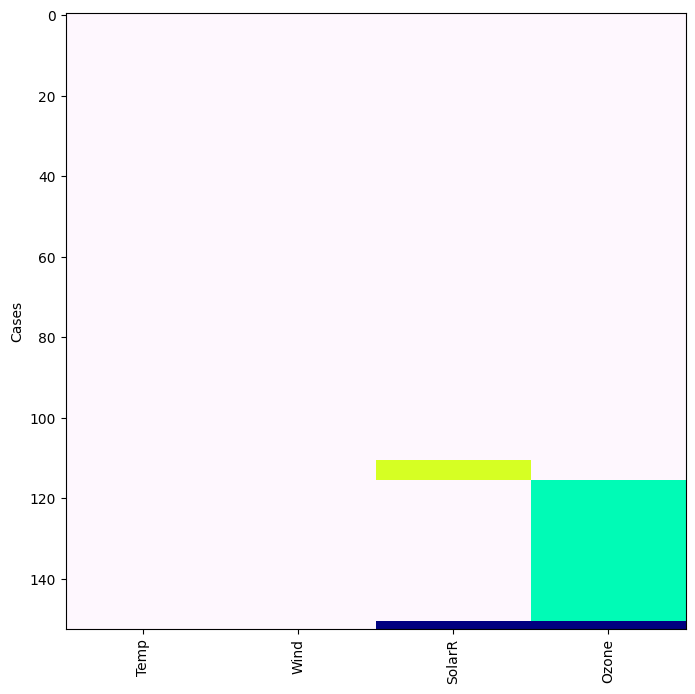

In [21]:
ax = imp.plot_missing_pattern()

La couleur désigne le type de manquant (e.g. bleu foncé = solar.R et Ozone manquants), et l'épaisseur le nombre d'individus 

On note que certains individus ont simultanément *SolarR* et *Ozone* manquants. La classe MICEData ne dispose pas d'une fonction pour récupérer le l'ensemble des patterns et leur fréquence. On la crée donc.

In [22]:
def get_missing_pattern(miceData):
    cols = miceData.data.columns

    miss = np.zeros(miceData.data.shape)

    for j, col in enumerate(cols):
        ix = miceData.ix_miss[col]
        miss[ix, j] = 1
    miss = pd.DataFrame(miss, columns=cols, dtype=int)

    count = miss.groupby(list(cols)).size()
    count = count.reset_index()
    count.rename({0: "count"}, axis=1, inplace=True)

    return count

In [23]:
get_missing_pattern(imp)

,Ozone,SolarR,Wind,Temp,count
0,0,0,0,0,111
1,0,1,0,0,5
2,1,0,0,0,35
3,1,1,0,0,2


Un profil (pattern) de données manquantes est donc un vecteur avec les éléments 0 ou 1 avec 0 = donnée présente, 1 = donnée manquante. Les 4 premières colonnes décrivent le pattern de manquants et la dernière (**count**), le nombre d'individus suivant ce pattern. Dans notre exemple, il y a 35 individus avec uniquement *Ozone* comme manquant.

#### MCAR, MAR ou MNAR

Afin de mettre un modèle sur les données manquantes, visualiser les croisements deux à deux des variables est utile.

In [ ]:
def compare_distribution(X, variable1, variable2):
    fig, ax = plt.subplots(
        nrows=3,
        ncols=3,
        sharex="col",
        sharey="row",
        gridspec_kw={"width_ratios": [4, 0.5, 1.25], "height_ratios": [4, 0.5, 1.25]},
    )

    # create a categorical variable indicating if the value is missing or not
    X_temp = X.copy()
    X_temp["var1_status"] = np.array([variable1 + " present", variable1 + " missing"])[np.isnan(X[variable1]) * 1]
    X_temp["var2_status"] = np.array([variable2 + " present", variable2 + " missing"])[np.isnan(X[variable2]) * 1]

    # plot the non-missing values
    sns.scatterplot(data=X, x=variable1, y=variable2, ax=ax[0, 0])

    # plot the variable2 values when the variable1 is missing
    sns.scatterplot(
        data=X_temp[X_temp["var1_status"] == variable1 + " missing"], x=0, y=variable2, color="tab:orange", ax=ax[0, 1]
    )
    ax[0, 1].axes.xaxis.set_visible(False)

    # boxplot of variable2 with regards to the fact that variable1 is missing or not
    sns.boxplot(
        data=X_temp,
        y=variable2,
        hue="var1_status",
        palette={variable1 + " present": "tab:blue", variable1 + " missing": "tab:orange"},
        ax=ax[0, 2],
    )
    ax[0, 2].yaxis.label.set_visible(False)
    ax[0, 2].legend(loc="upper left", bbox_to_anchor=(0, 0))

    # plot the variable1 values when the variable2 is missing
    sns.scatterplot(
        data=X_temp[X_temp["var2_status"] == variable2 + " missing"], x=variable1, y=0, color="tab:orange", ax=ax[1, 0]
    )
    ax[1, 0].axes.yaxis.set_visible(False)

    # boxplot of variable1 with regards to the fact that variable2 is missing or not
    sns.boxplot(
        data=X_temp,
        x=variable1,
        hue="var2_status",
        palette={variable2 + " present": "tab:blue", variable2 + " missing": "tab:orange"},
        orient="h",
        ax=ax[2, 0],
    )
    ax[2, 0].legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax[2, 0].yaxis.label.set_visible(False)

    ax[1, 1].axis("off")
    ax[1, 2].axis("off")
    ax[2, 1].axis("off")
    ax[2, 2].axis("off")
    fig.suptitle("")

    return ax

Par exemple :

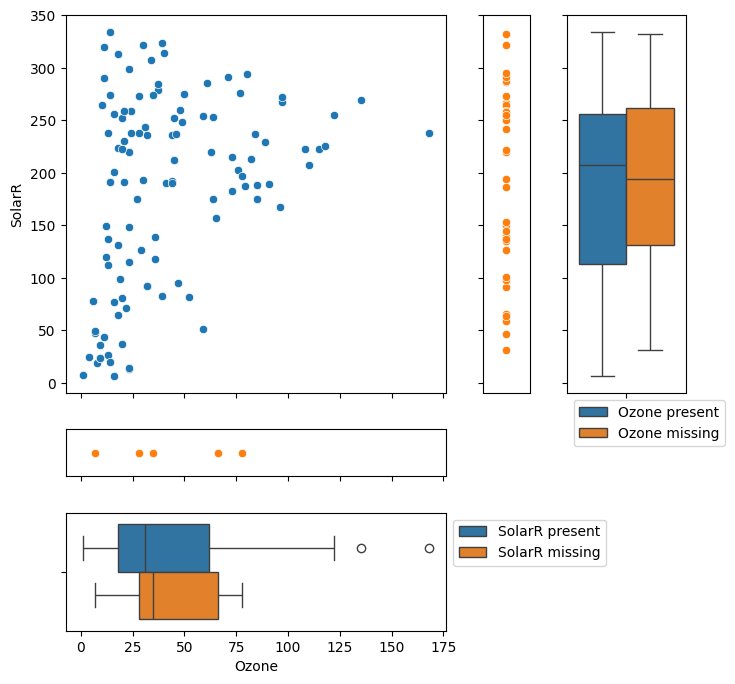

In [25]:
compare_distribution(X, "Ozone", "SolarR")
plt.show()

## Imputation

### Imputation des données manquantes

Pour chaque variable, la méthode par défaut utilisée est une régression linéaire. Cela peut être changé variable par variable avec la fonction [`set_imputer`](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.set_imputer.html#statsmodels.imputation.mice.MICEData.set_imputer). Cette fonction permet de définir le modèle utilisé, la formule et d'autres paramètres.

La méthode `update_all(n_iter)` effectue `n_iter` itérations (une itération = une mise à jour de chaque variable) de l'algorithme MICE.

In [ ]:
imp.update_all(n_iter=1)  # Code équivalent : imp.next_sample()
imp.head()

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,6.0,25.0,14.3,56
...,...,...,...,...
148,30.0,193.0,6.9,70
149,9.0,145.0,13.2,77
150,14.0,191.0,14.3,75
151,18.0,131.0,8.0,76


### Visualisation de la distribution d'une variable en fonction d'une variable avec manquant

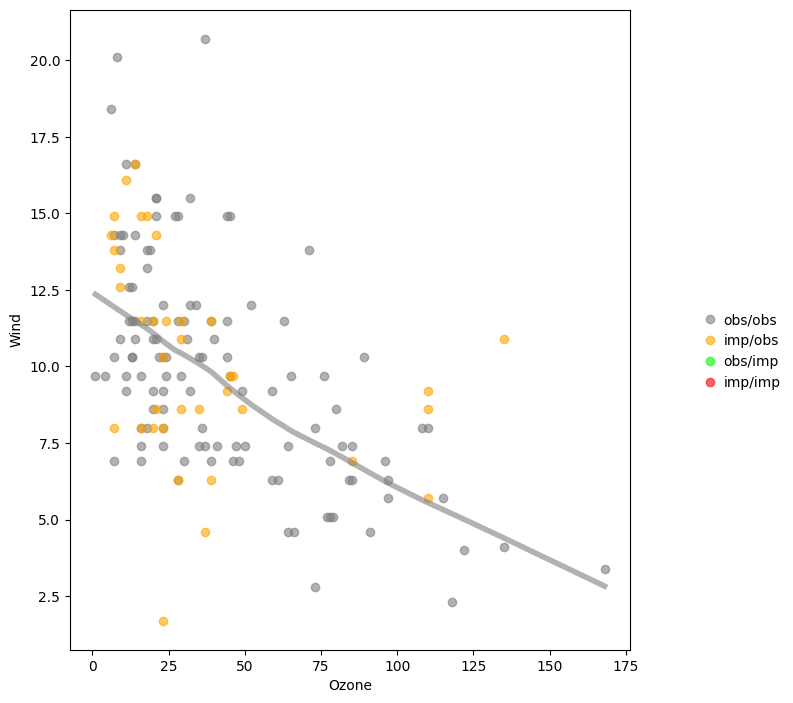

In [27]:
imp.plot_bivariate("Ozone", "Wind")
plt.show()

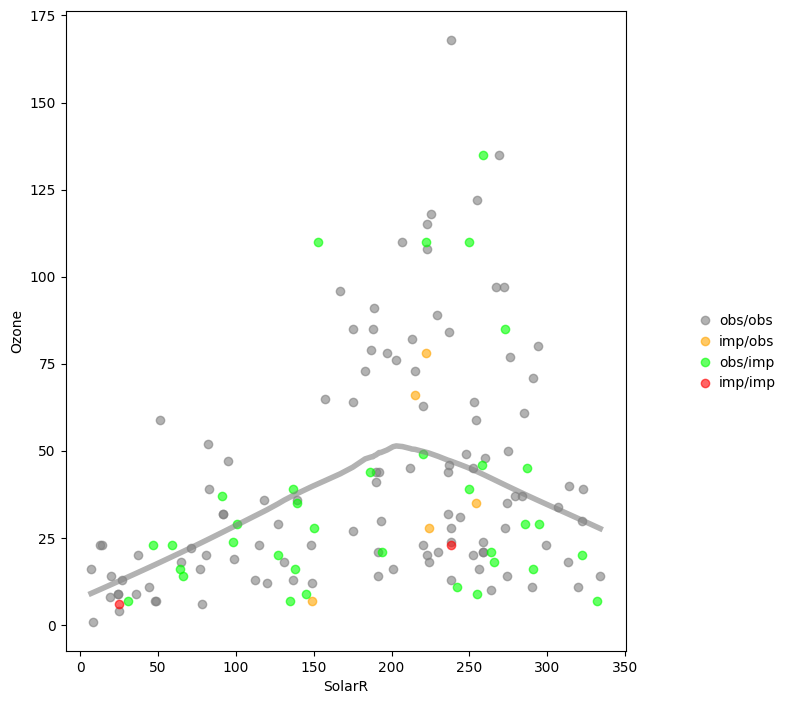

In [28]:
imp.plot_bivariate("SolarR", "Ozone")
plt.show()

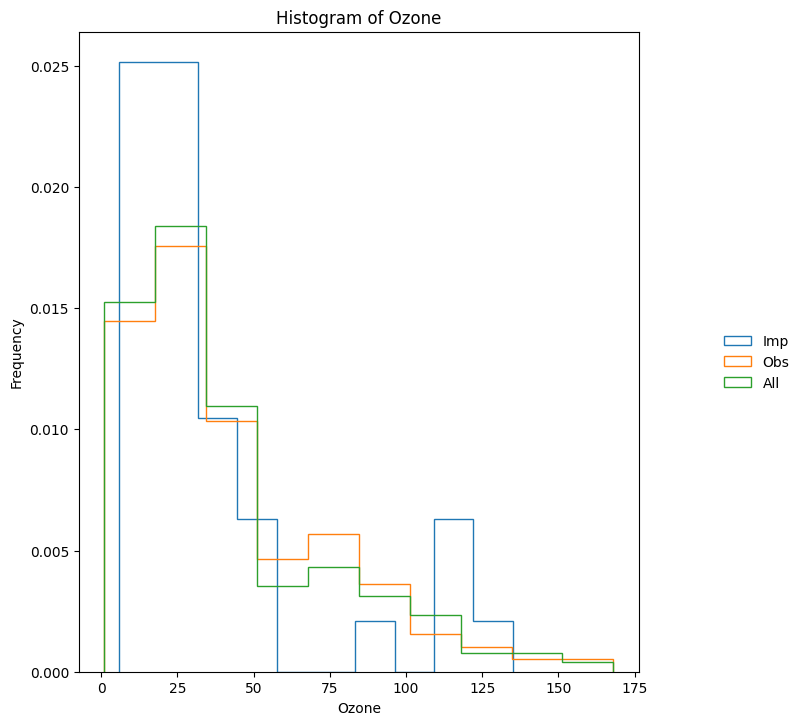

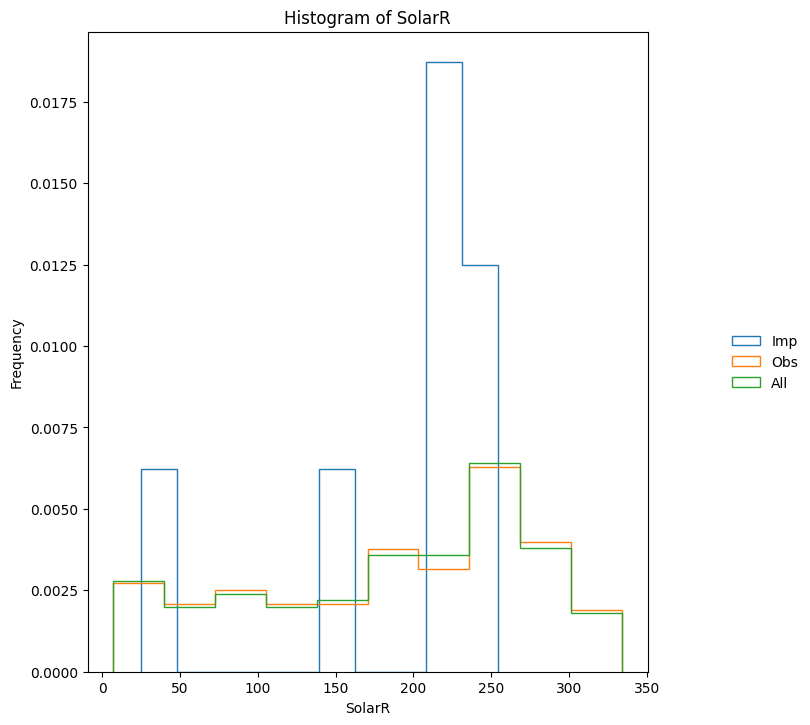

In [29]:
for var_name in ["Ozone", "SolarR"]:
    ax = imp.plot_imputed_hist(
        var_name, imp_hist_args={"density": True}, obs_hist_args={"density": True}, all_hist_args={"density": True}
    )
    plt.title("Histogram of " + var_name)
    plt.show()

## Imputation multiple

Pour obtenir des imputations, on fait faire des itérations à l'algorithme et on les sauvegarde.

In [30]:
n_imputation = 10
n_burn_iter = 5

imp.update_all(n_burn_iter)  # n_burn_iter itérations sans sauvegarder

imputed_data = []
for m in range(n_imputation):
    data = imp.next_sample()  # effectue 1 itération et retourne les données
    imputed_data.append(data.copy())  # on sauvegarde les données

Un jeu de données imputées.

In [31]:
imputed_data[1]

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,14.0,8.0,14.3,56
...,...,...,...,...
148,30.0,193.0,6.9,70
149,14.0,145.0,13.2,77
150,14.0,191.0,14.3,75
151,18.0,131.0,8.0,76


In [32]:
print(imputed_data[0].head())
imputed_data[0].describe()

   Ozone  SolarR  Wind  Temp
0   41.0   190.0   7.4    67
1   36.0   118.0   8.0    72
2   12.0   149.0  12.6    74
3   18.0   313.0  11.5    62
4   19.0   190.0  14.3    56


,Ozone,SolarR,Wind,Temp
count,153.000000,153.000000,153.000000,153.000000
mean,40.503268,187.477124,9.957516,77.882353
std,33.865664,89.744160,3.523001,9.465270
min,1.000000,7.000000,1.700000,56.000000
25%,16.000000,118.000000,7.400000,72.000000
50%,28.000000,207.000000,9.700000,79.000000
75%,59.000000,259.000000,11.500000,85.000000
max,168.000000,334.000000,20.700000,97.000000


In [33]:
def plot_imputed_data(mice_data, imputed_data, variable):
    df_list = []
    for i in range(len(imputed_data)):
        df_temp = pd.DataFrame()
        df_temp[variable] = imputed_data[i][variable].reset_index(drop=True)
        df_temp["Imputation"] = i
        df_temp["miss"] = False
        df_temp.loc[mice_data.ix_miss[variable], "miss"] = True
        df_list.append(df_temp)

    df = pd.concat(df_list)

    ax = sns.stripplot(data=df, x="Imputation", y=variable, hue="miss")

    return ax

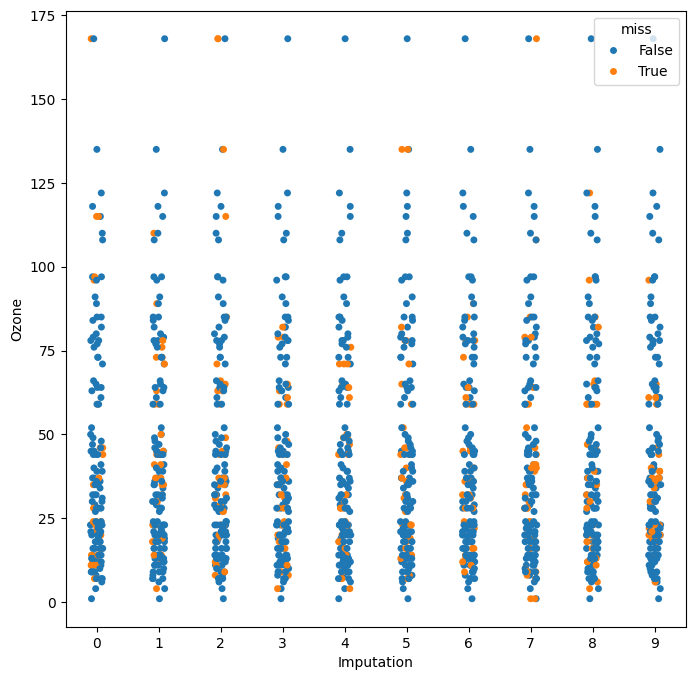

In [34]:
plot_imputed_data(imp, imputed_data, "Ozone")
plt.show()

## Regression linéaire dans le contexte de l’imputation multiple

Pour appliquer un modèle de régression sur plusieurs jeux de données imputées, nous utilisons [`mice.Mice`](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICE.html). Il prend notamment en arguments la formule, le modèle, un objet `MICEData`. La méthode `fit` de l'objet va imputer et appliquer le modèle fourni (ici une régression linéaire avec `sm.OLS`). On lui précise le nombre de burn-in itérations (itérations à faire avant de garder la 1ère imputation) et le nombre d'imputations à faire.

In [35]:
formula = "Ozone ~ SolarR + Wind + Temp"
mice_fit = mice.MICE(formula, sm.OLS, imp, n_skip=3)  # n_skip : nombre d'itérations à faire entre 2 imputations
results = mice_fit.fit(n_burnin=5, n_imputations=10)

In [36]:
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: MICE
====================================================================
Method:                    MICE        Sample size:           153   
Model:                     OLS         Scale                  461.36
Dependent variable:        Ozone       Num. imputations       10    
--------------------------------------------------------------------
           Coef.   Std.Err.    t    P>|t|    [0.025   0.975]   FMI  
--------------------------------------------------------------------
Intercept -64.9814  22.3322 -2.9098 0.0036 -108.7517 -21.2111 0.2423
SolarR      0.0676   0.0213  3.1706 0.0015    0.0258   0.1094 0.1132
Wind       -2.9561   0.6471 -4.5681 0.0000   -4.2244  -1.6878 0.2551
Temp        1.5850   0.2412  6.5717 0.0000    1.1123   2.0577 0.2001
====================================================================

"""

La statistique *FMI* représente la part de variance de l’estimateur due à l’imputation. Une valeur trop grande montre que l’imputation est probablement inappropriée dans ce cas. Une valeur < 0.3 est généralement tolérée.

In [37]:
results.frac_miss_info

array([0.24227312, 0.11323083, 0.25510177, 0.20014326])

Les coefficients moyens :

In [38]:
results.params

array([-64.9814212 ,   0.0675941 ,  -2.95611497,   1.58500081])

D'autres éléments que l'on peut récupérer :

In [39]:
results.normalized_cov_params

array([[ 1.08099590e+00,  6.59479550e-05, -2.25059647e-02,
        -1.10353463e-02],
       [ 6.59479550e-05,  9.85137192e-07, -2.60710635e-06,
        -2.91275207e-06],
       [-2.25059647e-02, -2.60710635e-06,  9.07675019e-04,
         1.77031707e-04],
       [-1.10353463e-02, -2.91275207e-06,  1.77031707e-04,
         1.26084781e-04]])

In [40]:
results.scale

np.float64(461.3586811417366)

In [41]:
results.tvalues

array([-2.90976445,  3.17059732, -4.5681124 ,  6.57171628])

In [42]:
results.pvalues

array([3.61701245e-03, 1.52125864e-03, 4.92136117e-06, 4.97385715e-11])

Récupérer tous les coefficients :

In [43]:
params = []
for i in range(n_imputation):
    params.append(mice_fit.results_list[i].params)

params = pd.concat(params, axis=1, ignore_index=True)

In [44]:
params

,0,1,2,3,4,5,6,7,8,9
Intercept,-60.205825,-51.210607,-68.003973,-80.901241,-49.195145,-78.320454,-67.380741,-69.356435,-67.639262,-57.600530
SolarR,0.081776,0.058108,0.070318,0.067166,0.072638,0.068576,0.058563,0.065245,0.068717,0.064833
Wind,-3.053646,-3.382057,-3.162568,-2.667976,-3.481447,-2.509480,-2.842955,-2.724838,-2.857864,-2.878319
Temp,1.501409,1.490164,1.650952,1.752247,1.439403,1.693633,1.641582,1.609145,1.587292,1.484183


Effectuer une prédiction avec les différents modèles :

In [45]:
data_to_pred = X.iloc[:2]
data_to_pred

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72


In [46]:
pred = np.zeros((len(results.model.results_list), len(data_to_pred)))
for i in range(len(results.model.results_list)):
    pred[i, :] = results.model.results_list[i].predict(data_to_pred)

La 1ère colonne contient les prédictions des modèles pour le 1er individu (vraie valeur : 41) et la 2ème pour le 2ème individu (vrai valeur : 36)

In [47]:
pred

array([[33.32903593, 33.11602475],
       [34.64372007, 35.88149958],
       [32.56711329, 33.86146576],
       [29.51787623, 31.84234868],
       [35.28341064, 35.16160078],
       [29.61218225, 31.63720171],
       [32.69444325, 34.98000807],
       [30.6889692 , 32.40216526],
       [30.6173811 , 31.89149109],
       [32.85848297, 33.88440745]])

Dans le cas de la régression linéaire, la prédiction avec les coefficients moyens est équivalente à la moyenne des prédictions de chaque modèle:

In [48]:
np.mean(pred, axis=0)

array([32.18126149, 33.46582131])

Ou directement avec les coefficients moyens :

In [49]:
results.params[0] + data_to_pred[mice_fit.exog_names[1:]].values.dot(results.params[1:])

array([32.18126149, 33.46582131])